## Get acts

In [1]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from collections import defaultdict
import os
import pickle
from tqdm import tqdm

In [2]:
model_name = 'llama-2-13B-GPTQ-4bit'
device='cuda:0'
# datasets = ['cities', 'neg_cities', 'sp_en_trans']
# layers = list(range(8, 15))
# datasets = ['neg_sp_en_trans', 'larger_than', 'smaller_than', 'cities_cities_conj', 'cities_cities_disj', 'companies_true_false', 'common_claim_true_false']
# layers = [14]

# model_name = 'llama-13B-GPTQ-4bit'
# device='cuda:0'
# datasets = ['cities']
# layers = [13]

In [3]:
model_name_or_path = f'/storage/models/{model_name}'
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="cuda:0")
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [ ]:
for dataset in datasets:
    print(dataset)
    statements = pd.read_csv(f'/notebooks/got-replication/datasets/{dataset}.csv')['statement'].tolist()
    layer_to_acts = defaultdict(list)
    for statement in tqdm(statements):
        input_ids = tokenizer(statement, return_tensors='pt').input_ids.cuda()
        output = model(input_ids, output_hidden_states=True)
        for layer in layers:
            layer_acts = output['hidden_states'][layer+1][0][-1].to('cpu').detach().numpy() # first hidden is emb layer, so +1
            layer_to_acts[layer].append(layer_acts)
    
    dataset_path = f'/notebooks/got-replication/acts/{model_name}/{dataset}'
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    
    # save layer acts for this dataset
    for layer in layer_to_acts:
        with open(f'{dataset_path}/{layer}.pkl', 'wb') as f:
            pickle.dump(layer_to_acts[layer], f)

cities


100%|██████████| 1496/1496 [00:57<00:00, 25.91it/s]


## Plot PCA

In [4]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import pickle

In [5]:
def load_acts(datasets, layer, center=True):
    all_data = pd.DataFrame()
    for dataset in datasets:
        data = pd.read_csv(f'/notebooks/got-replication/datasets/{dataset}.csv')
        with open(f'/notebooks/got-replication/acts/{model_name}/{dataset}/{layer}.pkl', 'rb') as f:
            acts = pickle.load(f)
        acts = np.array(acts)
        if center:
            acts = acts - np.mean(acts, axis=0)
        data['acts'] = acts.tolist()
        data['dataset'] = dataset
        all_data = pd.concat([all_data, data])
        
    return all_data

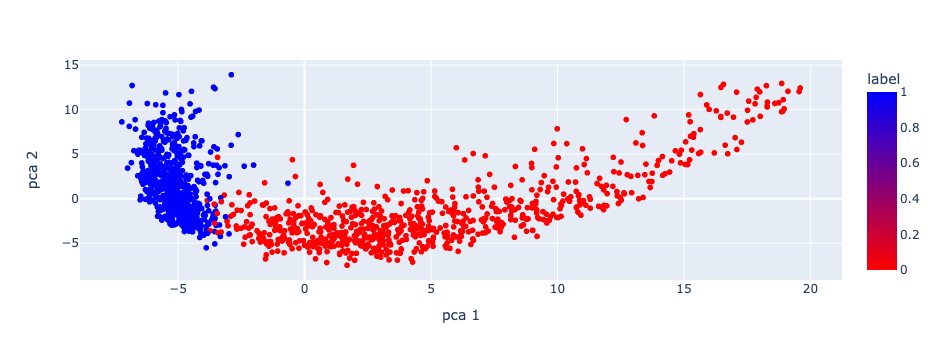

In [85]:
pca_datasets = ['cities']

data = load_acts(pca_datasets, 14)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.array(data['acts'].tolist()))
data[['pca 1', 'pca 2']] = X_pca
    
fig = px.scatter(data, x='pca 1', y='pca 2', color='label', color_continuous_scale='Bluered_r')
fig.show()

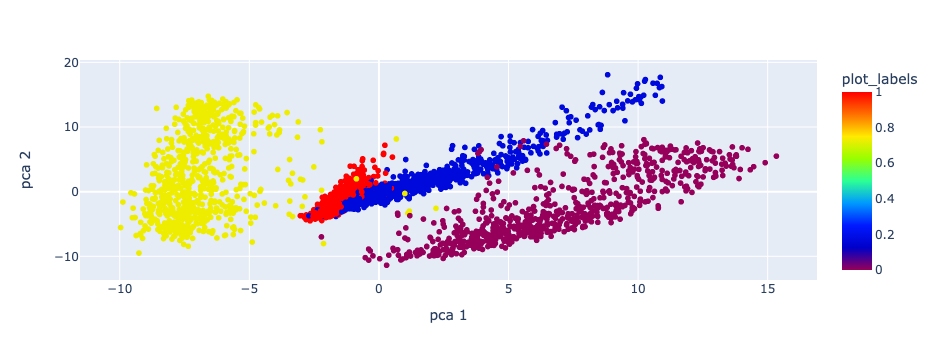

In [21]:
pca_datasets = ['cities', 'neg_cities']

data = load_acts(pca_datasets, 14)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.array(data['acts'].tolist()))
data[['pca 1', 'pca 2']] = X_pca

RED = 1
BLUE = .17
PURPLE = 0
YELLOW = .73

def color_labels(row):
    if row['dataset'] == pca_datasets[0]:
        return RED if row['label']==1 else BLUE
    elif row['dataset'] == pca_datasets[1]:
        return YELLOW if row['label']==1 else PURPLE
    
data['plot_labels'] = data.apply(lambda row: color_labels(row), axis=1)
    
fig = px.scatter(data, x='pca 1', y='pca 2', color='plot_labels')
fig.update_coloraxes(colorscale='Rainbow')
fig.show()

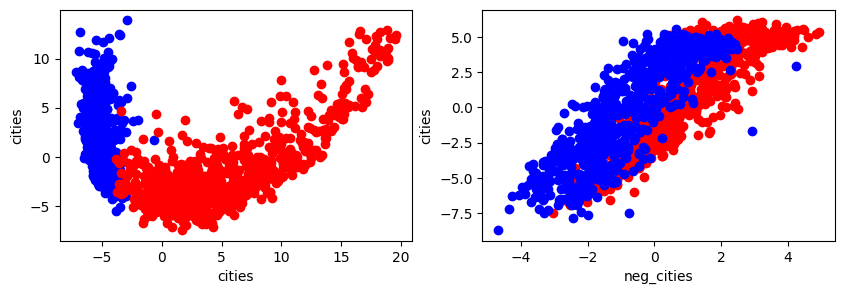

In [23]:
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

pca_datasets = ['cities']
plot_datasets = ['cities', 'neg_cities']

pca_data = load_acts(pca_datasets, 14)
pca = PCA(n_components=2)
pca.fit(np.array(pca_data['acts'].tolist()))

fig, axes = plt.subplots(nrows=1, ncols=len(plot_datasets), figsize=(10,3))
for i, dataset in enumerate(plot_datasets):
    plot_data = load_acts([dataset], 14)
    X_pca = pca.transform(np.array(plot_data['acts'].tolist()))
    plot_data[['pca 1', 'pca 2']] = X_pca
    for label in plot_data['label'].unique():
        subset = plot_data[plot_data['label'] == label]
        axes[i].scatter(subset['pca 1'], subset['pca 2'], color='blue' if label==1 else 'red')
        axes[i].set_xlabel(dataset)
        axes[i].set_ylabel('/'.join(pca_datasets))
fig.show()

## Create probes

In [404]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import logistic

class LRProbe():
    def __init__(self):
        self.classifier = LogisticRegression(fit_intercept=False)

    def fit(self, x_train, y_train):
        self.classifier.fit(x_train, y_train)
        
    def evaluate_probe(self, x_test, y_test):
        y_pred_class = self.classifier.predict(x_test)
        acc = (y_pred_class == y_test).mean()
        return acc
        
    def get_direction(self):
        return self.classifier.coef_
    
class MMProbe():
    def __init__(self):
        self.direction = None
    
    def fit(self, x_train, y_train):
        true_mean = x_train[y_train==1].mean(axis=0)
        false_mean = x_train[y_train==0].mean(axis=0)
        self.direction = true_mean - false_mean
        
    def evaluate_probe(self, x_test, y_test):
        y_pred_class = logistic.cdf(self.direction @ x_test.T) > .5
        acc = (y_pred_class == y_test).mean()
        return acc
    
    def get_direction(self):
        return self.direction
    


In [405]:
probe_type = MMProbe()

train_frac = .8
# train_dataset = [['cities'], ['cities', 'neg_cities']]
# test_datasets = ['cities', 'neg_cities', 'sp_en_trans']
train_datasets = [['cities'], ['cities', 'neg_cities'], ['larger_than'], ['larger_than', 'smaller_than']]
test_datasets = ['cities', 'neg_cities', 'larger_than', 'smaller_than', 'sp_en_trans', 'neg_sp_en_trans', 'cities_cities_conj', 'cities_cities_disj', 'companies_true_false', 'common_claim_true_false']

accs = defaultdict(list)
for train_dataset in train_datasets:
    print(f'Training with: {train_dataset}')
    data = load_acts(train_dataset, 14)
    data = data.sample(frac=1)
    x = np.array(data['acts'].tolist())
    y = np.array(data['label'].tolist())
    train_size = int(train_frac * len(data))
    x_train, y_train = x[:train_size], y[:train_size]

    # Train
    probe = probe_type
    probe.fit(x_train, y_train)

    # Evaluate on test datasets
    for dataset in test_datasets:
        print(f'Evaluating on {dataset}')
        if dataset not in train_datasets:
            test_data = load_acts([dataset], 14)
        else:
            # only use 20% that was not in train
            subset = data[train_size:]
            test_data = subset.loc[subset['dataset'] == dataset]
        x_test = np.array(test_data['acts'].tolist())
        y_test = np.array(test_data['label'].tolist())

        acc = probe.evaluate_probe(x_test, y_test)
        accs['/'.join(train_dataset)].append(acc)    

Training with: ['cities']
Evaluating on cities
Evaluating on neg_cities
Evaluating on larger_than
Evaluating on smaller_than
Evaluating on sp_en_trans
Evaluating on neg_sp_en_trans
Evaluating on cities_cities_conj
Evaluating on cities_cities_disj
Evaluating on companies_true_false
Evaluating on common_claim_true_false
Training with: ['cities', 'neg_cities']
Evaluating on cities
Evaluating on neg_cities
Evaluating on larger_than
Evaluating on smaller_than
Evaluating on sp_en_trans
Evaluating on neg_sp_en_trans
Evaluating on cities_cities_conj
Evaluating on cities_cities_disj
Evaluating on companies_true_false
Evaluating on common_claim_true_false
Training with: ['larger_than']
Evaluating on cities
Evaluating on neg_cities
Evaluating on larger_than
Evaluating on smaller_than
Evaluating on sp_en_trans
Evaluating on neg_sp_en_trans
Evaluating on cities_cities_conj
Evaluating on cities_cities_disj
Evaluating on companies_true_false
Evaluating on common_claim_true_false
Training with: ['larg

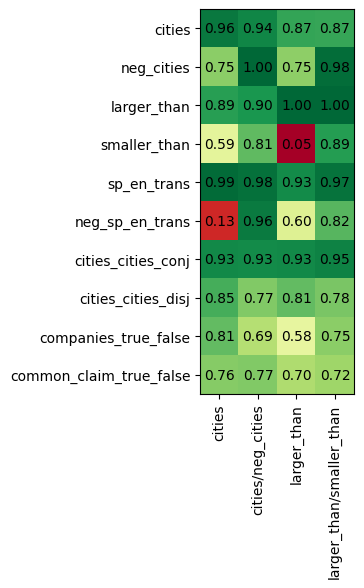

In [406]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

train_dataset_names = ['/'.join(dataset) for dataset in train_datasets]
data = np.array([accs[name] for name in train_dataset_names]).T  
fig, ax = plt.subplots(figsize=(15,5))
cax = ax.matshow(data, cmap='RdYlGn')

ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False) 
ax.set_xticks(np.arange(len(train_datasets)))
ax.set_yticks(np.arange(len(test_datasets)))
ax.set_xticklabels(train_dataset_names, rotation=90)#, ha='left')
ax.set_yticklabels(test_datasets)

for (i, j), val in np.ndenumerate(data):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Adding a color bar
# fig.colorbar(cax, label='Accuracy')

plt.show()

## Intervention

In [408]:
train_dataset = ['cities', 'neg_cities']
probe_layer = 14
probe_type = MMProbe() #LRProbe()

data = load_acts(train_dataset, probe_layer)
data = data.sample(frac=1)
x = np.array(data['acts'].tolist())
y = np.array(data['label'].tolist())

# Train
probe = probe_type
probe.fit(x, y)

In [409]:
import torch.nn.functional as F

data = load_acts(train_dataset, probe_layer)
direction = torch.tensor(probe.get_direction(), device='cuda:0', dtype=torch.float).view(-1)
true_acts = torch.tensor(data.loc[data['label'] == 1]['acts'].tolist(), dtype=torch.float).to(device)
false_acts = torch.tensor(data.loc[data['label'] == 0]['acts'].tolist(), dtype=torch.float).to(device)
true_mean = torch.mean(true_acts, dim=0)
false_mean = torch.mean(false_acts, dim=0)
norm_direction = F.normalize(direction, p=2.0, dim=0)
diff = (true_mean - false_mean) @ norm_direction
scaled_direction = norm_direction * diff
scaled_direction

tensor([ 0.0822,  0.1819,  0.1014,  ..., -0.1974,  0.0164,  0.0270],
       device='cuda:0')

In [410]:
intervention_dataset = 'sp_en_trans'
intervention_layers = range(8, 15)
random_seed = 10
data = pd.read_csv(f'/notebooks/got-replication/datasets/{intervention_dataset}.csv')
prompt_data = data.sample(n=5, replace=False, random_state=random_seed)
prompt = ''
for _, row in prompt_data.iterrows():
    prompt += f"{row['statement']} This statement is: {'TRUE' if row['label']==1 else 'FALSE'}\n"
prompt = prompt.rstrip('\n')
print(prompt)

The Spanish word 'morir' means 'to die'. This statement is: TRUE
The Spanish word 'anguila' means 'south'. This statement is: FALSE
The Spanish word 'pensar' means 'to think'. This statement is: TRUE
The Spanish word 'viejo' means 'old'. This statement is: TRUE
The Spanish word 'siempre' means 'month'. This statement is: FALSE


In [415]:
import torch

true_token = tokenizer(f'TRUE', return_tensors='pt').input_ids[0][1]
false_token = tokenizer(f'FALSE', return_tensors='pt').input_ids[0][1]
period_token = tokenizer.encode(f"'lost'.")[-1]

for module in model.model.layers:
    module._forward_hooks.clear()
    
results = {}
for label in [0, 1]:
    orig_pds = []
    mod_pds = []
    statements = data.loc[data['label'] == label]['statement'].tolist()
    for statement in tqdm(statements):
        if statement in prompt:
            continue
        input_ids = tokenizer(f'{prompt}\n{statement} This statement is:', return_tensors='pt').input_ids.cuda()

        # orig
        orig_output = model(input_ids, use_cache=False)
        orig_logits = torch.nn.functional.softmax(orig_output.logits[0, -1, :], dim=0)
        orig_pd = orig_logits[true_token].item() - orig_logits[false_token].item()

        # mod
        handles = []
        period_idx = torch.nonzero(input_ids[0] == period_token)[-1].item()
        def hook(m, inp, op):
            if label == 0:
                op[0][0, period_idx, :] += scaled_direction
                op[0][0, period_idx-1, :] += scaled_direction
            else:
                op[0][0, period_idx, :] -= scaled_direction
                op[0][0, period_idx-1, :] -= scaled_direction
            return op
        for layer in intervention_layers:
            # per https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L710, 
            # the first value in module output (used in hook) is the input to the layer...hence to overwrite layer n's output we should modify n+1's output
            h = model.model.layers[layer+1].register_forward_hook(hook)
            handles.append(h)
        mod_output = model(input_ids, use_cache=False)
        mod_logits = torch.nn.functional.softmax(mod_output.logits[0, -1, :], dim=0)
        mod_pd = mod_logits[true_token].item() - mod_logits[false_token].item()
        for h in handles:
            h.remove()
        orig_pds.append(orig_pd)
        mod_pds.append(mod_pd)
    orig_pd_mean = torch.mean(torch.tensor(orig_pds)).item()
    mod_pd_mean = torch.mean(torch.tensor(mod_pds)).item()
    results[f'{label}'] = orig_pd_mean
    results[f'{label}*'] = mod_pd_mean

100%|██████████| 177/177 [00:36<00:00,  4.82it/s]


In [416]:
results

{'0': -0.7885228395462036,
 '0*': 0.41585561633110046,
 '1': 0.9178896546363831,
 '1*': -0.6907753944396973}

In [417]:
# false->true nie
(results['0*'] - results['0']) / (results['1'] - results['0'])

0.705795615059787

In [414]:
# true-> false nie
(results['1*'] - results['1']) / (results['0'] - results['1'])

0.9427175753578095